In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
import datetime

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.functions import to_date
from pyspark.sql.functions import split
import category_encoders as ce
from pyspark.sql.functions import lit
from pyspark.sql.functions import expr
from pyspark.sql.types import IntegerType
from sklearn import linear_model
from sklearn.model_selection import learning_curve, GridSearchCV
sc = SparkContext('local')
spark = SparkSession(sc)

# Data Cleaning and Preprocessing

In [2]:
# load the target and predictor dataset
df = spark.read.csv('/Users/apple/Desktop/data/COVID19_dataset_Test1.csv', inferSchema = True, header = True)
df.show(5)

+-------------------+---------+---------------------------+----------------------------+-----------------+------------------+---------------+
|      Date_reported|  Country|Two Week Cases after 1 week|Two Week Deaths after 1 week| Cumulative_cases| Cumulative_deaths| Total Existed |
+-------------------+---------+---------------------------+----------------------------+-----------------+------------------+---------------+
|2020-01-03 00:00:00|Australia|                        0.0|                         0.0|              0.0|               0.0|            0.0|
|2020-01-04 00:00:00|Australia|                        0.0|                         0.0|              0.0|               0.0|            0.0|
|2020-01-05 00:00:00|Australia|                        0.0|                         0.0|              0.0|               0.0|            0.0|
|2020-01-06 00:00:00|Australia|                        0.0|                         0.0|              0.0|               0.0|            0.0|
|2020-

In [3]:
# change column names for conveniences
df = df.withColumnRenamed(" Country","Country")\
    .withColumnRenamed(" Cumulative_cases","Cumulative_cases")\
    .withColumnRenamed(" Cumulative_deaths","Cumulative_deaths")\
    .withColumnRenamed(" Total Existed ","Total_Existed")\
    .withColumnRenamed("Two Week Cases after 1 week","y_cases")\
    .withColumnRenamed("Two Week Deaths after 1 week","y_deaths")
df.show(5)

+-------------------+---------+-------+--------+----------------+-----------------+-------------+
|      Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|
+-------------------+---------+-------+--------+----------------+-----------------+-------------+
|2020-01-03 00:00:00|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|2020-01-04 00:00:00|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|2020-01-05 00:00:00|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|2020-01-06 00:00:00|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|2020-01-07 00:00:00|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
+-------------------+---------+-------+--------+----------------+-----------------+-------------+
only showing top 5 rows



In [4]:
df.dtypes

[('Date_reported', 'timestamp'),
 ('Country', 'string'),
 ('y_cases', 'double'),
 ('y_deaths', 'double'),
 ('Cumulative_cases', 'double'),
 ('Cumulative_deaths', 'double'),
 ('Total_Existed', 'double')]

Change the Date_reported column into Date Type

In [5]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")  #python3.8
df = df.withColumn('Date_reported',to_date(df.Date_reported))
df.show(5)

+-------------+---------+-------+--------+----------------+-----------------+-------------+
|Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|
+-------------+---------+-------+--------+----------------+-----------------+-------------+
|   2020-01-03|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|   2020-01-04|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|   2020-01-05|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|   2020-01-06|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
|   2020-01-07|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|
+-------------+---------+-------+--------+----------------+-----------------+-------------+
only showing top 5 rows



# Feature Engineering

Notice now we have 3 features: cumulative cases, cumulative deaths and the geographical region of the target country.
The daily covid tests will also be the possible feature that influence the cumulative cases and deaths.

In [6]:
# load the daily test dataset
df_test = spark.read.csv('/Users/apple/Desktop/data/Daily_Testing_Test1.csv', inferSchema = True, header = True)

# Dealing with NAs in total_tests column
df_test = df_test.fillna({' total_tests ':0})

# change date type
df_test = df_test.withColumn('date',to_date(df_test.date))
df_test = df_test.withColumn("total_tests", df_test[" total_tests "].cast(IntegerType()))
df_test = df_test.drop(" total_tests ")

df_test.show(5)

+---------+----------+-----------+
| location|      date|total_tests|
+---------+----------+-----------+
|Australia|2020-01-03|          0|
|Australia|2020-01-04|          0|
|Australia|2020-01-05|          0|
|Australia|2020-01-06|          0|
|Australia|2020-01-07|          0|
+---------+----------+-----------+
only showing top 5 rows



In [7]:
# join two tables using sql queries
spark.catalog.dropTempView("df")
spark.catalog.dropTempView("df_test")

df.createTempView('df')
df_test.createTempView('df_test')

df = spark.sql("SELECT * FROM df, df_test WHERE df.Date_reported = df_test.date and df.Country = df_test.location")

df = df.drop("location").drop("date")
df.show(5)

+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+
|Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|total_tests|
+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+
|   2020-01-03|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|
|   2020-01-04|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|
|   2020-01-05|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|
|   2020-01-06|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|
|   2020-01-07|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|
+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+
only showing top 5 rows



In [8]:
# load the OxCGRT_Dataset
df_OxCGRT = spark.read.csv('/Users/apple/Desktop/data/OxCGRT_Dataset.csv', inferSchema = True, header = True)

# Dealing with NAs in total_tests column
df_OxCGRT = df_OxCGRT.fillna({'School closing':0,'Workplace closing':0,'Cancel public events':0,'Stay at home requirements':0,'International travel controls':0,})

# change date type
df_OxCGRT = df_OxCGRT.withColumn('Date',to_date(df_OxCGRT.Date))
df_OxCGRT.show(5)

+----------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+
|      Date|CountryName|School closing|Workplace closing|Cancel public events|Stay at home requirements|International travel controls|
+----------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+
|2020-01-01|  Australia|             0|                0|                   0|                        0|                            0|
|2020-01-02|  Australia|             0|                0|                   0|                        0|                            0|
|2020-01-03|  Australia|             0|                0|                   0|                        0|                            0|
|2020-01-04|  Australia|             0|                0|                   0|                        0|                            0|
|2020-01-05|  Australia|             0|                

In [9]:
# join tables using sql queries
spark.catalog.dropTempView("df")
spark.catalog.dropTempView("df_OxCGRT")

df.createTempView('df')
df_OxCGRT.createTempView('df_OxCGRT')

df = spark.sql("SELECT * FROM df, df_OxCGRT WHERE df.Date_reported = df_OxCGRT.Date and df.Country = df_OxCGRT.CountryName")

df = df.drop("CountryName").drop("Date")
df.show(5)

+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+
|Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|total_tests|School closing|Workplace closing|Cancel public events|Stay at home requirements|International travel controls|
+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+
|   2020-01-03|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|             0|                0|                   0|                        0|                            0|
|   2020-01-04|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|             0|                0|        

The next feature is the travel ban condition: 1 represents the travel ban and 0 represents the free of travel ban. We use dummy variable 0 and 1 as features in the dataframe.

In [10]:
# create new column called 'Travel Ban Condition'
df = df.withColumn('Travel Ban Condition' ,lit(0))

# switch column value to 1 one the travel ban condition is announced
df = df.withColumn('Travel Ban Condition', sf.when(
    (df.Country == 'Australia') & (df.Date_reported >= datetime.datetime(2020, 3, 20)), 1
).when(
    (df.Country == 'Brazil') & (df.Date_reported >= datetime.datetime(2020, 3, 23)), 1
).when(
    (df.Country == 'India') & (df.Date_reported >= datetime.datetime(2020, 3, 20)), 1
).when(
    (df.Country == 'Spain') & (df.Date_reported >= datetime.datetime(2020, 3, 17)), 1
).when(
    (df.Country == 'United States of America') & (df.Date_reported >= datetime.datetime(2020, 3, 19)), 1
).otherwise(0))

df.show(5)

+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+--------------------+
|Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|total_tests|School closing|Workplace closing|Cancel public events|Stay at home requirements|International travel controls|Travel Ban Condition|
+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+--------------------+
|   2020-01-03|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|             0|                0|                   0|                        0|                            0|                   0|
|   2020-01-04|Australia|    0.0|     0.0|             0.0| 

Another possible feature is the Restaurant Closing, 1 represents closed and 0 represents the open. We use dummy variable 0 and 1 as features in the dataframe.

In [11]:
# create new column called 'Restaurant Restriction'
df = df.withColumn('Restaurant Restriction' ,lit(0))

# switch column value to 1 one the travel ban condition is announced
df = df.withColumn('Restaurant Restriction', sf.when(
    (df.Country == 'Australia') & (df.Date_reported <= datetime.datetime(2020, 3, 22)), 0
).when(
    (df.Country == 'Brazil') & (df.Date_reported <= datetime.datetime(2020, 5, 12))|(df.Date_reported >= datetime.datetime(2020, 7, 4)), 0
).when(
    (df.Country == 'India') & (df.Date_reported <= datetime.datetime(2020, 3, 25))|(df.Date_reported  >= datetime.datetime(2020, 6, 8)), 0
).when(
    (df.Country == 'Spain') & (df.Date_reported <= datetime.datetime(2020, 3, 29))|(df.Date_reported >= datetime.datetime(2020, 7, 25)), 0
).when(
    (df.Country == 'United States of America') & (df.Date_reported <= datetime.datetime(2020, 3, 16))|(df.Date_reported >= datetime.datetime(2020, 7, 4)), 0
).otherwise(1))
df.show(5)


+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+--------------------+----------------------+
|Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|total_tests|School closing|Workplace closing|Cancel public events|Stay at home requirements|International travel controls|Travel Ban Condition|Restaurant Restriction|
+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+--------------------+-------------------------+-----------------------------+--------------------+----------------------+
|   2020-01-03|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|             0|                0|                   0|                        0|                            0|             

In [12]:
df = df.withColumnRenamed("Travel Ban Condition","Travel_Ban_Condition")\
    .withColumnRenamed("School closing","School_closing")\
    .withColumnRenamed("Workplace closing","Workplace_closing")\
    .withColumnRenamed("Cancel public events","public_events")\
    .withColumnRenamed("Stay at home requirements","Stay_at_home")\
    .withColumnRenamed("International travel controls","travel_controls")\
    .withColumnRenamed("Restaurant Restriction","Restaurant_Restriction")
df.show(5)

+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+-------------+------------+---------------+--------------------+----------------------+
|Date_reported|  Country|y_cases|y_deaths|Cumulative_cases|Cumulative_deaths|Total_Existed|total_tests|School_closing|Workplace_closing|public_events|Stay_at_home|travel_controls|Travel_Ban_Condition|Restaurant_Restriction|
+-------------+---------+-------+--------+----------------+-----------------+-------------+-----------+--------------+-----------------+-------------+------------+---------------+--------------------+----------------------+
|   2020-01-03|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0|             0|                0|            0|           0|              0|                   0|                     0|
|   2020-01-04|Australia|    0.0|     0.0|             0.0|              0.0|          0.0|          0| 

# Exploratory Data Analysis

In [13]:
# First we convert our final dataframe to pandas data frame
df.toPandas().to_csv('Covid19_final.csv')

df = df.toPandas()

One hot encoding for Country feature

In [14]:
encoder = ce.OneHotEncoder(use_cat_names=True)
country_encoded = encoder.fit_transform(df["Country"])
df = pd.concat([df, country_encoded], axis=1)
df

,Date_reported,Country,y_cases,y_deaths,Cumulative_cases,Cumulative_deaths,Total_Existed,total_tests,School_closing,Workplace_closing,public_events,Stay_at_home,travel_controls,Travel_Ban_Condition,Restaurant_Restriction,Country_Australia,Country_Brazil,Country_India,Country_Spain,Country_United States of America
0,2020-01-03,Australia,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2020-01-04,Australia,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2020-01-05,Australia,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2020-01-06,Australia,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2020-01-07,Australia,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,2020-08-27,United States of America,261151.0,4998.0,5719841.0,177332.0,3765234.0,869783,3,2,2,1,3,1,0,0,0,0,0,1
1206,2020-08-28,United States of America,253737.0,5095.0,5765325.0,178561.0,3794389.0,1136760,3,2,2,1,3,1,0,0,0,0,0,1
1207,2020-08-29,United States of America,246302.0,5100.0,5811519.0,179716.0,3818162.0,864623,3,2,2,1,3,1,0,0,0,0,0,1
1208,2020-08-30,United States of America,242694.0,5146.0,5855521.0,180689.0,3840191.0,623064,3,2,2,1,3,1,0,0,0,0,0,1


In [15]:
df.dtypes

Date_reported                        object
Country                              object
y_cases                             float64
y_deaths                            float64
Cumulative_cases                    float64
Cumulative_deaths                   float64
Total_Existed                       float64
total_tests                           int32
School_closing                        int32
Workplace_closing                     int32
public_events                         int32
Stay_at_home                          int32
travel_controls                       int32
Travel_Ban_Condition                  int32
Restaurant_Restriction                int32
Country_Australia                     int64
Country_Brazil                        int64
Country_India                         int64
Country_Spain                         int64
Country_United States of America      int64
dtype: object

Get summary statistics

In [16]:
# for cumulative cases
df_temp = df.groupby(['Country'])['Cumulative_cases'].describe()
print(df_temp)

                          count          mean           std  min     25%  \
Country                                                                    
Australia                 242.0  7.018876e+03  7.132078e+03  0.0   37.00   
Brazil                    242.0  8.055585e+05  1.152044e+06  0.0    6.25   
India                     242.0  5.223024e+05  8.980501e+05  0.0   14.50   
Spain                     242.0  1.639969e+05  1.328736e+05  0.0  123.25   
United States of America  242.0  1.625239e+06  1.817318e+06  0.0  117.25   

                                50%        75%        max  
Country                                                    
Australia                    6775.0     7898.5    25670.0  
Brazil                      88484.5  1393579.5  3846153.0  
India                       38658.0   599854.0  3621245.0  
Spain                      219458.0   249720.5   473502.0  
United States of America  1080503.5  2606060.0  5899504.0  


In [17]:
# for cumulative deaths
df_temp = df.groupby(['Country'])['Cumulative_deaths'].describe()
print(df_temp)

                          count          mean           std  min   25%  \
Country                                                                  
Australia                 242.0     99.202479    129.929075  0.0  1.00   
Brazil                    242.0  30588.363636  38922.358140  0.0  0.00   
India                     242.0  11445.099174  17490.329674  0.0  0.00   
Spain                     242.0  17047.619835  12879.210365  0.0  2.50   
United States of America  242.0  67432.280992  64400.840356  0.0  2.75   

                              50%        75%       max  
Country                                                 
Australia                    93.0     104.00     611.0  
Brazil                     6115.0   59274.00  120462.0  
India                      1259.5   17725.50   64469.0  
Spain                     25470.5   28482.25   29409.0  
United States of America  64958.0  126993.00  181689.0  


In [18]:
# for total tests
df_temp = df.groupby(['Country'])['total_tests'].describe()
print(df_temp)

                          count           mean            std  min      25%  \
Country                                                                       
Australia                 242.0   25679.557851   24922.321333  0.0   2467.0   
Brazil                    242.0   21420.458678   30767.735691  0.0   1499.0   
India                     242.0  174826.090909  257936.503123  0.0    148.0   
Spain                     242.0   27993.376033   21300.964716  0.0  12920.0   
United States of America  242.0  372425.706612  357849.501831  0.0    755.0   

                               50%        75%        max  
Country                                                   
Australia                  15924.5   45178.25    94706.0  
Brazil                      9039.0   31053.00   161388.0  
India                      67369.0  220135.00  1055027.0  
Spain                      25677.0   42029.00    89466.0  
United States of America  294616.0  692733.25  1245943.0  


Time Series Plots

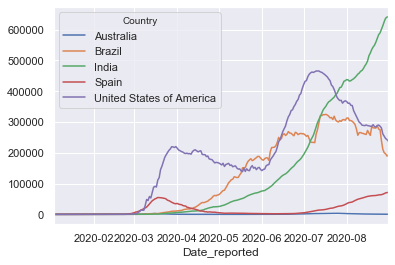

In [19]:
# Time Series Plot of cumulative cases
df_temp = df.pivot(index='Date_reported', columns='Country', values='y_cases')
df_temp.plot()

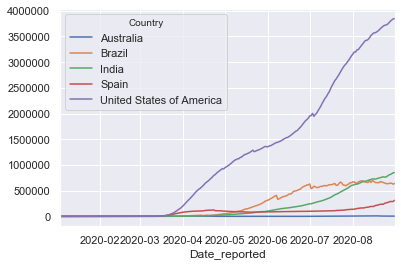

In [20]:
# Time Series Plot of cumulative cases
df_temp = df.pivot(index='Date_reported', columns='Country', values='Total_Existed')
df_temp.plot()

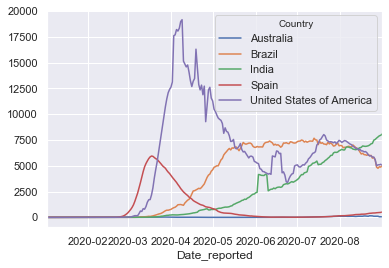

In [21]:
# Time Series Plot of cumulative deaths
df_temp = df.pivot(index='Date_reported', columns='Country', values='y_deaths')
df_temp.plot()

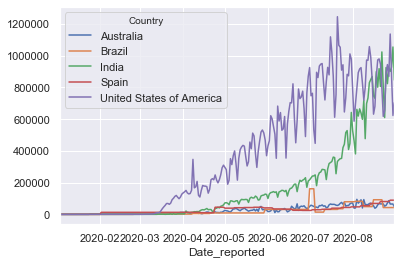

In [22]:
# Time Series Plot of total tests
df_temp = df.pivot(index='Date_reported', columns='Country', values='total_tests')
df_temp.plot()

Let's see the Scatter Plot:

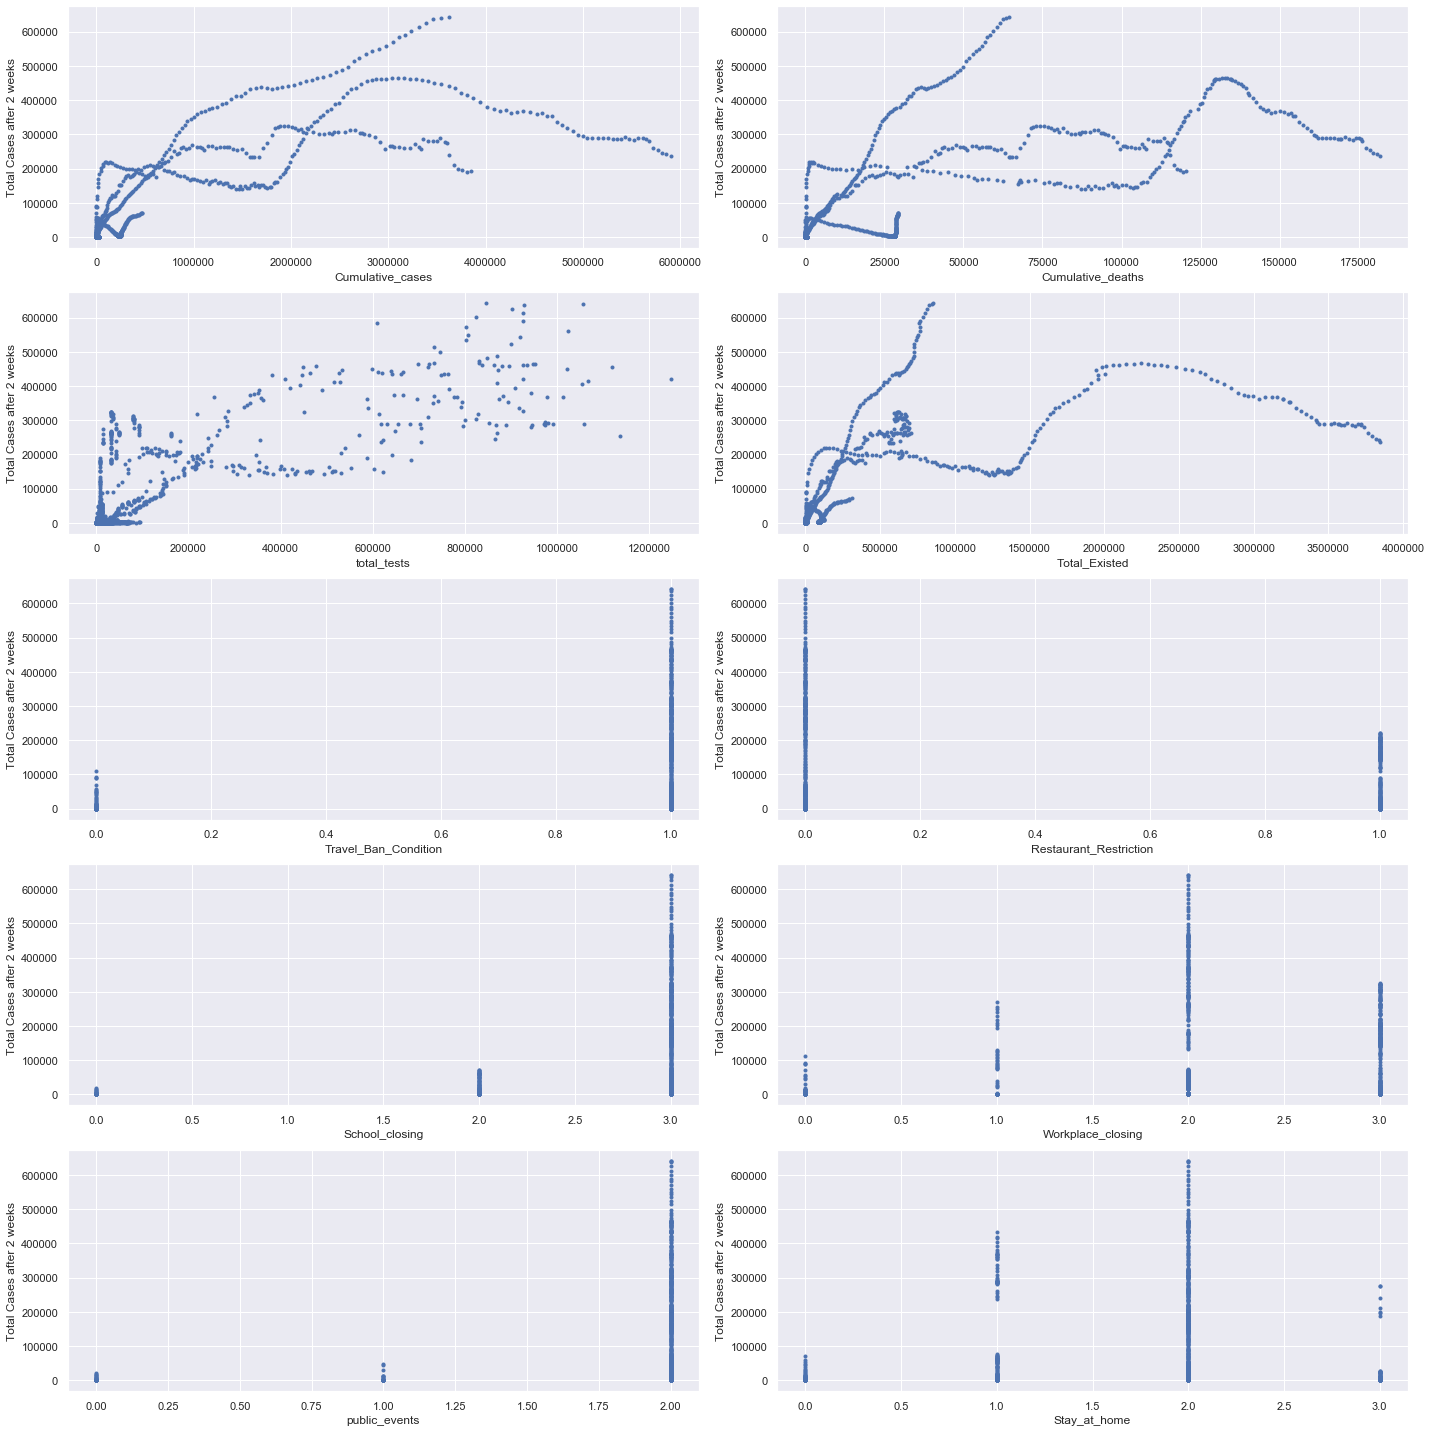

In [23]:
features=['Cumulative_cases','Cumulative_deaths','total_tests','Total_Existed','Travel_Ban_Condition','Restaurant_Restriction','School_closing','Workplace_closing','public_events','Stay_at_home']
X=df[features].to_numpy()
Y_1=df['y_cases'].to_numpy()
Y_2=df['y_deaths'].to_numpy()
plt.figure(figsize=(20,20))
feature_count=X.shape[1]

for i in range(feature_count):
        plt.subplot(5,2,i+1)
        plt.plot(X[:,i],Y_1,'.')
        plt.xlabel(features[i])
        plt.ylabel('Total Cases after 2 weeks')
plt.tight_layout()
plt.show()


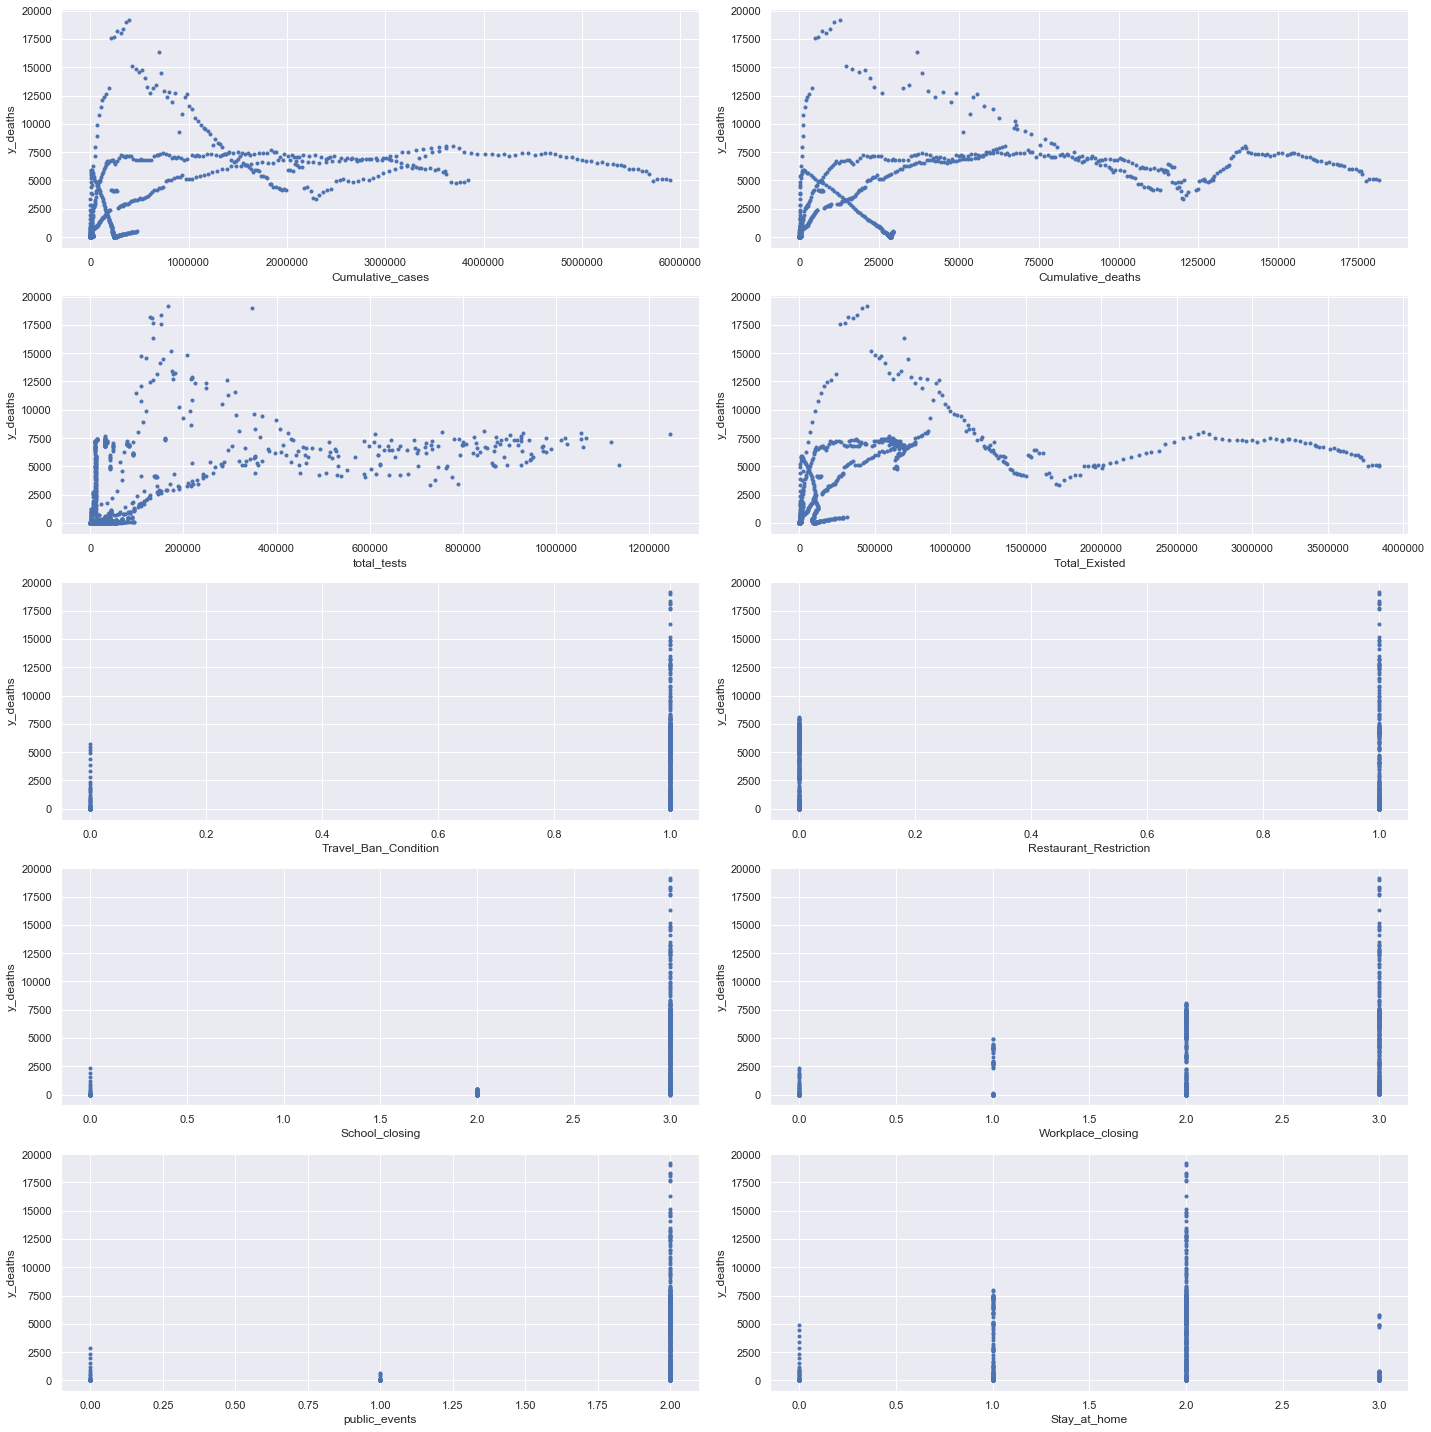

In [24]:
plt.figure(figsize=(20,20))
feature_count=X.shape[1]

for i in range(feature_count):
        plt.subplot(5,2,i+1)
        plt.plot(X[:,i],Y_2,'.')
        plt.xlabel(features[i])
        plt.ylabel('y_deaths')
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

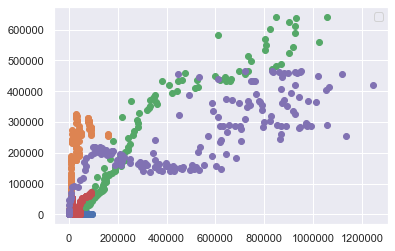

In [25]:
groups = df.groupby('Country')
# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.total_tests, group.y_cases, marker='o', linestyle='')
ax.legend()
plt.show

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

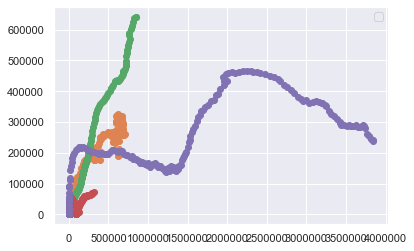

In [26]:
groups = df.groupby('Country')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Total_Existed, group.y_cases, marker='o', linestyle='')
ax.legend()

plt.show

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

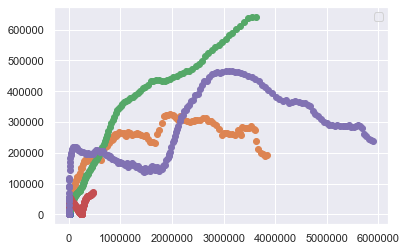

In [27]:
groups = df.groupby('Country')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Cumulative_cases, group.y_cases, marker='o', linestyle='')
ax.legend()

plt.show

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

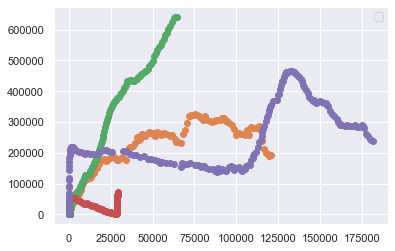

In [28]:
groups = df.groupby('Country')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Cumulative_deaths, group.y_cases, marker='o', linestyle='')
ax.legend()

plt.show

# Multivariate Linear Regression Modelling

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

In [54]:
# train test split (test set is for data in Month July and August)
train = df[(df.Date_reported < datetime.datetime(2020, 7, 1).date())]
test = df[(df.Date_reported >= datetime.datetime(2020, 7, 1).date())]

X = df.drop(['y_cases','y_deaths','Date_reported','Country'],axis=1)
# standardize the numerical dependent variables
X_train = train.drop(['y_cases','y_deaths','Date_reported','Country'],axis=1)
X_test = test.drop(['y_cases','y_deaths','Date_reported','Country'],axis=1)
Y1_train = train['y_cases']
Y1_test = test['y_cases']
Y2_train = train['y_deaths']
Y2_test = test['y_deaths']

In [55]:
lasso = linear_model.Lasso(max_iter=1000)
# perform hyperparameters tuning and cross-validation using GridSearchCV
parameters = {'alpha': [1e-5, 1e-2, 1, 3, 5]}

# 5-fold cross-validation
lasso_regressor = GridSearchCV(lasso, parameters, cv=5)

lasso_regressor.fit(X_train, Y1_train)

print(lasso_regressor.best_params_)

{'alpha': 1e-05}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277694521859.1634, tolerance: 529574461.0593999
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207165247473.74957, tolerance: 416335651.2024779
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310729069456.436, tolerance: 531376801.96017796
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

In [56]:
lasso_regressor_Y1 = linear_model.Lasso(1e-05, max_iter=1000)
lasso_regressor_Y1.fit(X_train,Y1_train)
print(pd.Series(lasso_regressor_Y1.coef_, index = X.columns)) # Print coefficients
print("R-square of cases prediction is "+str(lasso_regressor_Y1.score(X_train, Y1_train)*100)) # Print R-square

Cumulative_cases                        0.507993
Cumulative_deaths                      -6.761283
Total_Existed                          -0.006325
total_tests                            -0.122817
School_closing                       5285.615557
Workplace_closing                   -4415.741507
public_events                       -3481.421039
Stay_at_home                        10571.033406
travel_controls                      2762.113609
Travel_Ban_Condition                23625.396982
Restaurant_Restriction               7170.948209
Country_Australia                  -37575.299033
Country_Brazil                       3709.920565
Country_India                      -34739.360942
Country_Spain                        3264.305738
Country_United States of America    13993.916527
dtype: float64
R-square of cases prediction is 87.39887696441255


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363448801536.53534, tolerance: 576851487.6145
  positive)


In [57]:
pred = lasso_regressor_Y1.predict(X_test) # Use this model to predict the test data
print(mean_absolute_error(Y1_test, pred))  # Calculate the test MAE

299975.3464987788


In [58]:
lasso = linear_model.Lasso(max_iter=1000)
# perform hyperparameters tuning and cross-validation using GridSearchCV
parameters = {'alpha': [1e-5, 1e-2, 1, 3, 5]}

# 5-fold cross-validation
lasso_regressor = GridSearchCV(lasso, parameters, cv=5)
lasso_regressor.fit(X_train, Y2_train)

print(lasso_regressor.best_params_)

{'alpha': 5}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1175204032.0506394, tolerance: 975568.2541861113
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 969859724.1643829, tolerance: 882509.3143061112
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1242555851.4761956, tolerance: 1007959.9159977778
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

In [59]:
lasso_regressor_Y2 = linear_model.Lasso(5, max_iter=1000)
lasso_regressor_Y2.fit(X_train,Y2_train)
print(pd.Series(lasso_regressor_Y2.coef_, index = X.columns)) # Print coefficients
print("R-square of cases prediction is "+str(lasso_regressor_Y2.score(X_train, Y2_train)*100)) # Print R-square

Cumulative_cases                       0.006296
Cumulative_deaths                     -0.306656
Total_Existed                          0.022065
total_tests                           -0.017632
School_closing                       168.692067
Workplace_closing                    199.254548
public_events                         -0.000000
Stay_at_home                         277.770889
travel_controls                       68.660822
Travel_Ban_Condition                1710.128538
Restaurant_Restriction               390.454387
Country_Australia                  -1985.324451
Country_Brazil                         0.000000
Country_India                      -1616.343977
Country_Spain                       1080.574465
Country_United States of America     869.757263
dtype: float64
R-square of cases prediction is 71.42373604316285


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13491490.488057137, tolerance: 1061905.2642678889
  positive)


In [60]:
pred = lasso_regressor_Y2.predict(X_test) # Use this model to predict the test data
print(mean_absolute_error(Y2_test, pred))  # Calculate the test MAE

7007.4579476480285


In [61]:
# using the data for America a month ago (Data in Sep 23th):
X_prediction = np.asarray([[6898298, 193927, 4225960, 962736, 3, 2, 2, 1, 3, 1, 0, 0, 0, 0, 0, 1]])

predicted_cases = lasso_regressor_Y1.predict(X_prediction)
predicted_deaths = lasso_regressor_Y2.predict(X_prediction)

print("The predicted cases are " + str(predicted_cases))
print("The predicted deaths are " + str(predicted_deaths))

The predicted cases are [2112959.09148541]
The predicted deaths are [64549.9824557]


# Feature Importance Exploring Using Extra Trees Classifier 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

Feature Importance of predicting cumulative cases

In [ ]:
tree_model = ExtraTreesClassifier(random_state=0).fit(X, Y_1)
feature_importance  = tree_model.feature_importances_
sorted_feature = np.argsort(feature_importance)[::]

plt.figure(figsize=(20,10))
plt.title('Feature importances of predicting cases')
plt.barh(range(X.shape[1]), feature_importance[sorted_feature], align="center")
plt.yticks(range(X.shape[1]), [list(X.columns)[i] for i in sorted_feature])
plt.ylim([-1, X.shape[1]])
plt.show()

Feature Importance of predicting cumulative deaths

In [ ]:
tree_model = ExtraTreesClassifier(random_state=0).fit(X, Y_2)
feature_importance  = tree_model.feature_importances_
sorted_feature = np.argsort(feature_importance)[::]

plt.figure(figsize=(20,10))
plt.title('Feature importances of predicting deaths')
plt.barh(range(X.shape[1]), feature_importance[sorted_feature], align="center")
plt.yticks(range(X.shape[1]), [list(X.columns)[i] for i in sorted_feature])
plt.ylim([-1, X.shape[1]])
plt.show()